# Wind Turbine Accidents: A Data Mining Study

### Imports

In [28]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats
import scipy.special as sp
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree

https://strathprints.strath.ac.uk/64291/1/Pandit_Infield_RPG2018_SCADA_based_wind_turbine_anomaly_detection_using_Gaussian.pdf

In [29]:
raw_dataset = pd.read_csv('News.Database.csv')

In [30]:
pd.set_option('display.max_columns', None)

raw_dataset.head()

,Accident No,Accident type,Site/area\n,Country\n,Details\n,Web reference/link\n,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW),Offshore,During Construction,FULL-DATE,Outcome,Death,Fire,Injury,Mechanical,Structural Break,Transport Accident,Component,Cause,CauseCategory,Source Database,Source of the News,Title of the article
0,1.0,Wind,Tjaereborg,Denmark,Damage to all 3 blades,http://www.modernpowersystems.com/story.asp?st...,2002,11,4,Vestas 2000 KW,Vestas,2000,19000,1,0,"April 11, 2002",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Blade,Human (interference in control systems),Human,LexisNexis,Major World Publications,Bending with the wind
1,2.0,Wind,Jiangsu,China,5 died & 4 injured workers,http://www.chinadaily.com.cn/china/2012-03/11/...,2012,3,10,UNKNOWN,UNKNOWN,UNKNOWN,5000,1,1,"October 3, 2012",Structural break,1.0,0.0,1.0,0.0,1.0,0.0,UNKNOWN,Mechanical (platform collapse at construction ...,Mechanical,LexisNexis,Modern Power System,Death toll in China construction site accident...
2,3.0,Wind,Ireland,UK,The turbine came loose after bolts attaching i...,http://www.modernpowersystems.com/story.asp?st...,2009,1,UNKNOWN,Enercon 2000 KW,Enercon,2000,4000,0,0,UNKNOWN,Structural break,0.0,0.0,0.0,1.0,1.0,0.0,Bolt,Mechanical (material fatigue),Mechanical,LexisNexis,The Sunday Telegraph,ET 'not to blame'
3,4.0,Wind,"Berwickshire, Scotland",UK,A 30m turbine near Coldingham was deliberately...,http://www.windbyte.co.uk/safety.html,2011,12,7,Hannevind 22 KW,Hannevind,22,UNKNOWN,0,0,"December 7, 2011",Mechanical,0.0,0.0,0.0,1.0,0.0,0.0,Tower,Mechanical ( blade system failure),Mechanical,Google,windbyte.co.uk,Wind turbine safety
4,5.0,Wind,Ohio,USA,The fallen wind turbine was supplying power to...,http://www.vindy.com/news/2011/apr/11/wind-tur...,2011,4,10,Proven 15 KW,Proven,15,45,0,0,"April 11, 2011",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Tower,UNKNOWN,UNKNOWN,LexisNexis,vindy.com,Wind turbine failure western reserve high scho...


In [31]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Accident No            273 non-null    float64
 1   Accident type          273 non-null    object 
 2   Site/area
             273 non-null    object 
 3   Country
               273 non-null    object 
 4   Details
               273 non-null    object 
 5   Web reference/link
    273 non-null    object 
 6   Year                   273 non-null    object 
 7   Month                  273 non-null    object 
 8   Day                    273 non-null    object 
 9   Turbine Type           273 non-null    object 
 10  Manufacturer           273 non-null    object 
 11  Power of Turbine (KW)  273 non-null    object 
 12  PowerOfWindFarm (KW)   273 non-null    object 
 13  Offshore               83 non-null     object 
 14  During Construction    83 non-null     object 
 15  FULL-D

In [32]:
#Add new column, Afectted Humans
raw_dataset['Afectted Humans'] =raw_dataset['Death'] + raw_dataset['Injury']
raw_dataset['Afectted Humans'] = raw_dataset['Afectted Humans'].map({2.0: 1.0, 1.0:1.0,0.0:0.0})

#Add new column, Affected System/Equipment
raw_dataset['Affected System/Equipment'] =raw_dataset['Fire'] + raw_dataset['Structural Break'] + raw_dataset['Transport Accident']
raw_dataset['Affected System/Equipment'] = raw_dataset['Afectted Humans'].map({3.0:1.0,2.0: 1.0, 1.0:1.0,0.0:0.0})

#Drop useless columns
raw_dataset = raw_dataset.drop('Accident No', axis=1)
raw_dataset = raw_dataset.drop('Accident type', axis=1) 
raw_dataset = raw_dataset.drop('Source Database', axis=1)
raw_dataset = raw_dataset.drop('Source of the News', axis=1)
raw_dataset = raw_dataset.drop('Title of the article', axis=1)

#Rename columns
raw_dataset.columns = ['Site/area' if x=='Site/area\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Country' if x=='Country\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Details' if x=='Details\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Web reference/link' if x=='Web reference/link\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Onshore/Offshore' if x=='Offshore' else x for x in raw_dataset.columns]
raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].map({"1":"Offshore","0":"Onshore"})

df = raw_dataset.copy()

df.drop(df[df.isnull().sum(axis=1) > 7].index, inplace=True)

yDeath = df['Death']
yInjury = df['Injury']

df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

In [33]:
#gives a numerical value between 0 and 1 to all the data
enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

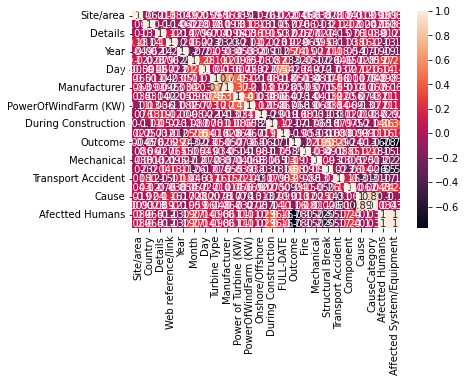

In [34]:
#correlation matrix
cr_mtx = df.corr()
sn.heatmap(cr_mtx, annot=True)
plt.show()

In [35]:
#Take the upper part of the matrix
upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))
cr_mtx = upper.fillna(0)

/tmp/ipykernel_2290/1963661821.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))


In [36]:
#Select the relevants pairs in the correlation matrix
lst = list(cr_mtx.columns.values)
c = []
for i in lst:
    for j in lst:
        if i != j and (cr_mtx[i][j] >= 0.2 or cr_mtx[i][j] <= -0.2) :
            c.append({i,j})

c            

[{'Web reference/link', 'Year'},
 {'Month', 'Year'},
 {'Day', 'Year'},
 {'Day', 'Month'},
 {'Turbine Type', 'Web reference/link'},
 {'Manufacturer', 'Web reference/link'},
 {'Manufacturer', 'Turbine Type'},
 {'Power of Turbine (KW)', 'Turbine Type'},
 {'Manufacturer', 'Power of Turbine (KW)'},
 {'Manufacturer', 'PowerOfWindFarm (KW)'},
 {'Power of Turbine (KW)', 'PowerOfWindFarm (KW)'},
 {'During Construction', 'Onshore/Offshore'},
 {'FULL-DATE', 'Year'},
 {'FULL-DATE', 'Month'},
 {'Day', 'FULL-DATE'},
 {'Outcome', 'Year'},
 {'Month', 'Outcome'},
 {'Day', 'Outcome'},
 {'Fire', 'Outcome'},
 {'Month', 'Structural Break'},
 {'Outcome', 'Structural Break'},
 {'Power of Turbine (KW)', 'Transport Accident'},
 {'Onshore/Offshore', 'Transport Accident'},
 {'Outcome', 'Transport Accident'},
 {'Component', 'Outcome'},
 {'Component', 'Structural Break'},
 {'Cause', 'Transport Accident'},
 {'CauseCategory', 'Transport Accident'},
 {'Cause', 'CauseCategory'},
 {'Afectted Humans', 'Month'},
 {'Afect

In [37]:
#Statistical Test
StatisticalTest = pd.DataFrame(columns=['Test No', 'Attribute1','Attribute2', 'Correlation', 'Test Performed' ,'p-Value', 'Result'])

for x in c :
    #print(x.pop() + "  " + x.pop())
    a = x.pop()
    b =x.pop()
    if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
        dfDropNa = df.dropna()
        #res = stats.fisher_exact(pd.crosstab(df[a], df[b], margins = False))
        #res = stats.fisher_exact(df[[a, b]])
        #if res[1] < 0.05 :
        #    ok = "-"  
        #else :
        #    ok = "+"
        #StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Fisher’s Test" , res[1], ok]
        
    elif raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.float64 :
        
        dfDropNa = df.dropna()
        
        res = stats.chi2_contingency(pd.crosstab(dfDropNa[a], dfDropNa[b], margins = False))
        if res[1] < 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Chi Square Pearson Test" , res[1], ok]
        
    else :
        dfDropNa = df.dropna()     
        
        res = stats.shapiro(dfDropNa[[a, b]])
        if res[1] < 0.05 : 
            res1 = stats.ttest_ind(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "T-Test" , res[1], ok]
        else :
            res1 = stats.kruskal(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Kruskal-Wallis Test" , res[1], ok]
    
StatisticalTest.sort_values('Correlation',ascending=[False] )

/tmp/ipykernel_2290/1704236093.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :


,Test No,Attribute1,Attribute2,Correlation,Test Performed,p-Value,Result
2,0,Structural Break,Outcome,0.577698,T-Test,1.509480e-15,+
10,0,Afectted Humans,During Construction,0.356176,T-Test,3.349045e-21,-
15,0,Affected System/Equipment,Month,0.266614,T-Test,3.035832e-14,+
9,0,Afectted Humans,Month,0.266614,T-Test,3.035832e-14,+
20,0,Affected System/Equipment,Component,0.240552,T-Test,2.693842e-17,-
14,0,Afectted Humans,Component,0.240552,T-Test,2.693842e-17,-
0,0,Outcome,Fire,0.000000,T-Test,2.906941e-15,-
19,0,Structural Break,Affected System/Equipment,0.000000,Chi Square Pearson Test,2.453475e-05,-
17,0,Outcome,Affected System/Equipment,0.000000,T-Test,9.597725e-15,-
16,0,During Construction,Affected System/Equipment,0.000000,T-Test,3.349045e-21,-


In [38]:
#Ranking of Attributes, Deaths
RankingD = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yDeath)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingD = RankingD.append(row, ignore_index= True)
    

RankingD.sort_values('Information Gain', ascending=[False])
#RankingD.sort_index()

,Attribute,Values,Information Gain
14,Outcome,48,0.649163
17,Structural Break,79,0.373016
2,Details,1,0.278826
16,Mechanical,177,0.265560
20,Cause,43,0.263250
18,Transport Accident,182,0.260163
15,Fire,181,0.255144
21,CauseCategory,73,0.222121
3,Web reference/link,20,0.194267
0,Site/area,9,0.186479


In [39]:
#Ranking of Attributes, Injuries
RankingI = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])

for cols in df.columns :
    res = sp.kl_div(df[cols] , yInjury)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingI = RankingI.append(row, ignore_index= True)
    

RankingI.sort_values('Information Gain', ascending=[False])

,Attribute,Values,Information Gain
3,Web reference/link,1,0.426796
20,Cause,22,0.316509
2,Details,1,0.256862
13,FULL-DATE,7,0.222014
21,CauseCategory,55,0.219063
17,Structural Break,93,0.211864
6,Day,15,0.211581
5,Month,30,0.180183
0,Site/area,4,0.179807
14,Outcome,22,0.155684


In [40]:
#Split the data into test and train
df = raw_dataset.copy()
df = df.dropna()
yDeath = df['Death']
yInjury = df['Injury']
df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Details", "Web reference/link", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

X_trainD, X_testD, y_trainD, y_testD = train_test_split(df, yDeath, test_size=0.33, random_state=42)
X_trainI, X_testI, y_trainI, y_testI = train_test_split(df, yInjury, test_size=0.33, random_state=42)

In [41]:
#Classifiers, deaths
# logistic regression, k-nearest neighbor (kNN), classification trees, support vector machines (SVM), and C4.5 
ClassifiersD = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

#LogisticRegression
model = LogisticRegression()
model.fit(X_trainD, y_trainD)
score = accuracy_score(y_testD, model.predict(X_testD))
roc = roc_auc_score(y_testD, model.predict(X_testD))
row = {'Classifier': "Logistic Regression", 'CA':score, 'AUC':roc}
roc_lr = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersD = ClassifiersD.append(row, ignore_index= True)

#K-nearest neighbor
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_trainD, y_trainD)
score = accuracy_score(y_testD, model.predict(X_testD))
roc = roc_auc_score(y_testD, model.predict(X_testD))
row = {'Classifier': "K-nearest neighbor", 'CA':score, 'AUC':roc}
roc_kn = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersD = ClassifiersD.append(row, ignore_index= True)

#SVM
model = svm.SVC()
model.fit(X_trainD, y_trainD)
score = accuracy_score(y_testD, model.predict(X_testD))
roc = roc_auc_score(y_testD, model.predict(X_testD))
row = {'Classifier': "SVM", 'CA':score, 'AUC':roc}
roc_svm = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersD = ClassifiersD.append(row, ignore_index= True)

#C4.5
model = tree.DecisionTreeClassifier()
model.fit(X_trainD, y_trainD)
score = accuracy_score(y_testD, model.predict(X_testD))
roc = roc_auc_score(y_testD, model.predict(X_testD))
row = {'Classifier': "C4.5", 'CA':score, 'AUC':roc}
roc_c45 = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersD = ClassifiersD.append(row, ignore_index= True)

ClassifiersD

,Classifier,CA,AUC
0,Logistic Regression,0.928571,0.857143
1,K-nearest neighbor,0.964286,0.928571
2,SVM,0.928571,0.904762
3,C4.5,0.892857,0.928571


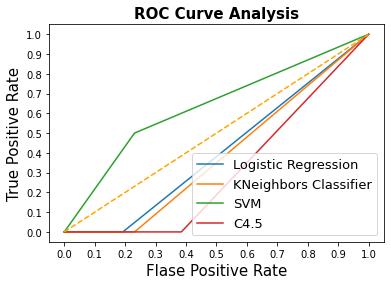

In [42]:
#ROC curve, deaths
plt.plot(roc_lr[0], roc_lr[1], label="Logistic Regression")
plt.plot(roc_kn[0], roc_kn[1], label="KNeighbors Classifier")
plt.plot(roc_svm[0], roc_svm[1], label="SVM")
plt.plot(roc_c45[0], roc_c45[1], label="C4.5")

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [43]:
#Classifiers, Injuries

ClassifiersI = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

#LogisticRegression
model = LogisticRegression()
model.fit(X_trainI, y_trainI)
score = accuracy_score(y_testI, model.predict(X_testI))
roc = roc_auc_score(y_testI, model.predict(X_testI))
row = {'Classifier': "Logistic Regression", 'CA':score, 'AUC':roc}
roc_lr = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersI = ClassifiersI.append(row, ignore_index= True)

#K-nearest neighbor
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_trainI, y_trainI)
score = accuracy_score(y_testI, model.predict(X_testI))
roc = roc_auc_score(y_testI, model.predict(X_testI))
row = {'Classifier': "K-nearest neighbor", 'CA':score, 'AUC':roc}
roc_kn = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersI = ClassifiersI.append(row, ignore_index= True)

#SVM
model = svm.SVC()
model.fit(X_trainI, y_trainI)
score = accuracy_score(y_testI, model.predict(X_testI))
roc = roc_auc_score(y_testI, model.predict(X_testI))
row = {'Classifier': "SVM", 'CA':score, 'AUC':roc}
roc_svm = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersI = ClassifiersI.append(row, ignore_index= True)

#C4.5
model = tree.DecisionTreeClassifier()
model.fit(X_trainI, y_trainI)
score = accuracy_score(y_testI, model.predict(X_testI))
roc = roc_auc_score(y_testI, model.predict(X_testI))
row = {'Classifier': "C4.5", 'CA':score, 'AUC':roc}
roc_c45 = metrics.roc_curve(y_testI, model.predict(X_testI))
ClassifiersI = ClassifiersI.append(row, ignore_index= True)

ClassifiersI

,Classifier,CA,AUC
0,Logistic Regression,0.928571,0.730769
1,K-nearest neighbor,1.000000,1.000000
2,SVM,0.928571,0.500000
3,C4.5,1.000000,1.000000


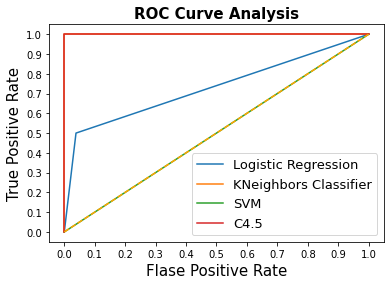

In [44]:
#ROC curve, Injuries
plt.plot(roc_lr[0], roc_lr[1], label="Logistic Regression")
plt.plot(roc_kn[0], roc_kn[1], label="KNeighbors Classifier")
plt.plot(roc_svm[0], roc_svm[1], label="SVM")
plt.plot(roc_c45[0], roc_c45[1], label="C4.5")

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()